# Lead Time Prediction Model
This notebook aims to predict the delivery lead time for orders based on various features related to the supply chain process. The goal is to help minimize delivery delays by accurately estimating lead times.


## Data Loading and Preparation
In this section, we load the dataset and prepare it for analysis, including handling missing values and converting data types as necessary.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('USAID_Health_Comodity_Delivery_CleanUp.csv')
# Convert the columns to datetime format if they are not already
df['Latest Actual Delivery Date'] = pd.to_datetime(df['Latest Actual Delivery Date'])
df['Order Entry Date'] = pd.to_datetime(df['Order Entry Date'])

# Create the new column
df['Actual Lead Time'] = df['Latest Actual Delivery Date'] - df['Order Entry Date']
df['Actual Lead Time'] = df['Actual Lead Time'].dt.days


/tmp/ipykernel_12724/582795690.py:5: DtypeWarning: Columns (50,51,52,64) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('USAID_Health_Comodity_Delivery_CleanUp.csv')


## Feature and Target Variable Definition
Modify the `features` and `target` variables as needed to fit your analysis. The current setup is aimed at predicting the Actual Lead Time based on selected features from the dataset.


In [2]:

# Define the features and target for the model
features = ['Country', 'Continent','Transportation Mode', 'Order Type', 'Fulfillment Method', 'Product Category', 'Vendor Incoterm', 'Reason Code', 'Item Tracer Category','Quality Assurance','Manufacture']
target = ['Actual Lead Time']


In [3]:
# Assuming df is your DataFrame
unique_countries = df['Country'].unique()
print(unique_countries)

['Mozambique' 'Zambia' 'South Africa' 'Congo DRC' 'Uganda' 'Rwanda'
 'Ethiopia' 'Zimbabwe' 'Haiti' "Côte d'Ivoire" 'Nigeria' 'Paraguay'
 'Nepal' 'Ghana' 'Tanzania' 'Liberia' 'Bhutan' 'Italy' 'Sierra Leone'
 'Bangladesh' 'Singapore' 'Ukraine' 'Afghanistan' 'Burundi' 'Angola'
 'Togo' 'Benin' 'Vietnam' 'Eswatini' 'Dominican Republic' 'Honduras'
 'Guinea' 'Mali' 'Senegal' 'Malawi' 'Tajikistan' 'Jamaica' 'Nicaragua'
 'Lesotho' 'Kenya' 'Cameroon' 'Belgium' 'Botswana' 'South Sudan' 'Namibia'
 'United Arab Emirates' 'Barbados' 'Suriname' 'Netherlands' 'Laos'
 'Guyana' 'El Salvador' 'Pakistan' 'Thailand' 'Mongolia'
 'Trinidad and Tobago' 'Bahamas' 'Myanmar' 'Madagascar' 'Peru' 'Nauru'
 'Indonesia' 'Ecuador' 'Uzbekistan' 'Philippines' 'Sri Lanka' 'Egypt'
 'Guatemala' 'Burkina Faso' 'Saint Vincent and the Grenadines'
 'Saint Kitts and Nevis' 'Colombia' 'Brazil' 'Russian Federation'
 'Tunisia' 'Yemen' 'Kazakhstan' 'Panama' 'India' 'Niger' 'Fiji' 'Maldives'
 'Saint Lucia' 'Mauritania' 'Antigua and 

Convert contries to regions

In [4]:
import pycountry_convert as pc

# Function to get continent name from country name
def get_continent(country):
    try:
        # Convert country name to country alpha2 code
        country_code = pc.country_name_to_country_alpha2(country)
        # Convert country alpha2 code to continent code
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        # Convert continent code to continent name
        continent_name = {
            'AF': 'Africa',
            'NA': 'North America',
            'OC': 'Oceania',
            'AN': 'Antarctica',
            'AS': 'Asia',
            'EU': 'Europe',
            'SA': 'South America'
        }.get(continent_code)
        return continent_name
    except:
        # Handle exceptions or specific country names
        special_cases = {
            "Congo DRC": "Africa",
            "Côte d'Ivoire": "Africa",
            "Republic of Kosovo": "Europe"
            # Add any other special cases here
        }
        return special_cases.get(country, 'Unknown')  # Return 'Unknown' if not found

# Apply the function to create a new continent column
df['Continent'] = df['Country'].apply(get_continent)


/home/nhatthuan97/anaconda3/lib/python3.11/site-packages/pycountry/db.py:51: UserWarning: Country's official_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)
/home/nhatthuan97/anaconda3/lib/python3.11/site-packages/pycountry/db.py:51: UserWarning: Country's common_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)


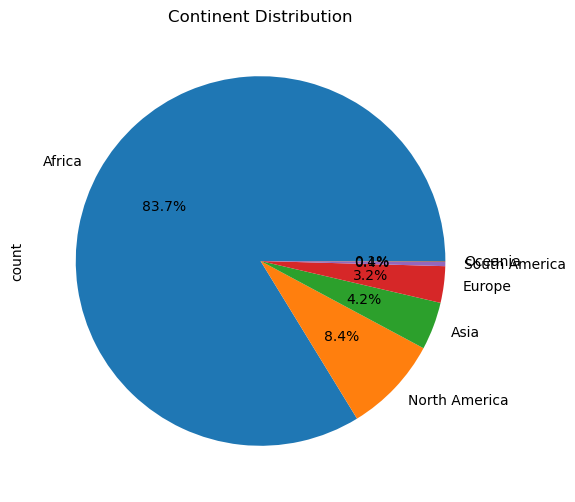

In [5]:
# Assuming df is your DataFrame and matplotlib.pyplot is imported as plt
continent_distribution = df['Continent'].value_counts()
plt.figure(figsize=(10, 6))
continent_distribution.plot(kind='pie', autopct='%1.1f%%')
plt.title('Continent Distribution')
plt.show()

In [6]:
# Assuming df is your DataFrame
continent_distribution = df['Continent'].value_counts(normalize=True) * 100
continent_distribution = continent_distribution.to_frame()
continent_distribution.columns = ['Percentage']
print(continent_distribution)

               Percentage
Continent                
Africa          83.739774
North America    8.437865
Asia             4.183872
Europe           3.191793
South America    0.379172
Oceania          0.067524


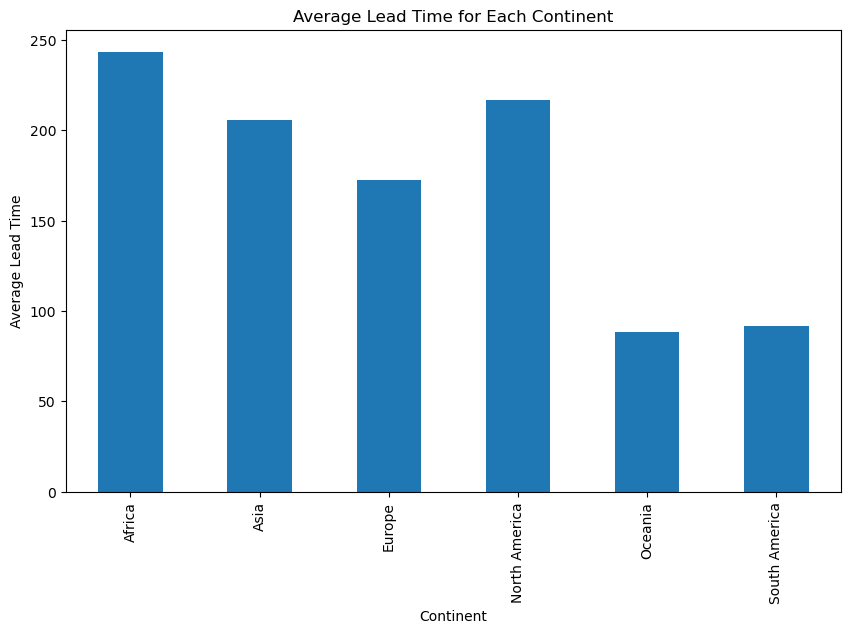

In [7]:
# Assuming df is your DataFrame and matplotlib.pyplot is imported as plt
average_lead_time = df.groupby('Continent')['Actual Lead Time'].mean()
plt.figure(figsize=(10, 6))
average_lead_time.plot(kind='bar')
plt.title('Average Lead Time for Each Continent')
plt.ylabel('Average Lead Time')
plt.show()

In [8]:
df = df[features + target]
df['Reason Code'] = df['Reason Code'].str.slice(0, 2)

In [9]:
df['Quality Assurance'] = df.groupby('Product Category')['Quality Assurance'].transform(lambda x: x.fillna(x.mean()))
df['Manufacture'] = df.groupby('Product Category')['Manufacture'].transform(lambda x: x.fillna(x.mean()))
df['Reason Code'] = df['Reason Code'].fillna('NoDelay')

In [10]:
print("All Product Categories")
unique_product_categories = df['Product Category'].unique()
print(unique_product_categories)

All Product Categories
['Others' 'Laboratory Consumables'
 'Voluntary Male Circumcision (VMMC) Kits' 'Laboratory Reagents'
 'Medical Supplies' 'Laboratory Equipment' 'Essential Medicines'
 'Office Equipment' 'Other Global Health Commodities' 'IT Equipment'
 'Nutritional Supplements' 'Female Condoms' 'Respiratory Support'
 'General Patient Care' 'Male Condoms' 'HIV/AIDS Pharmaceuticals'
 'Personal Lubricants' 'Injectable Contraceptives'
 'Malaria Pharmaceuticals' 'Diagnostic Tests'
 'Voluntary Male Circumcision (VMMC) Supplies' 'Intrauterine Devices'
 'Personal Protective Equipment (PPE)' 'Sanitation'
 'Pharmaceutical Treatment' 'Diagnostic Sample Collection'
 'HIV Rapid Test Kits (RTKs)' 'Warehouse Equipment'
 'Contraceptive Implants' 'Oral Contraceptives' 'Standard Days Method'
 'Long Lasting Insecticide Treated Nets (LLINs)'
 'Malaria Rapid Diagnostic Test (RDTs)' 'Vehicles']


In [11]:
# Assuming df is your DataFrame
nan_quality_assurance_categories = df[df['Quality Assurance'].isna()]['Product Category'].unique()
not_nan_quality_assurance_categories = df[df['Quality Assurance'].notna()]['Product Category'].unique()

print("Product Categories where Quality Assurance is NaN:")
print(nan_quality_assurance_categories)

print("Product Categories where Quality Assurance is not NaN:")
print(not_nan_quality_assurance_categories)

Product Categories where Quality Assurance is NaN:
['Others' 'Voluntary Male Circumcision (VMMC) Kits' 'Laboratory Reagents'
 'Medical Supplies' 'Office Equipment' 'Other Global Health Commodities'
 'IT Equipment' 'Nutritional Supplements' 'Female Condoms'
 'Respiratory Support' 'General Patient Care' 'Male Condoms'
 'HIV/AIDS Pharmaceuticals' 'Personal Lubricants'
 'Injectable Contraceptives' 'Diagnostic Tests'
 'Voluntary Male Circumcision (VMMC) Supplies' 'Intrauterine Devices'
 'Personal Protective Equipment (PPE)' 'Sanitation'
 'Pharmaceutical Treatment' 'Diagnostic Sample Collection'
 'HIV Rapid Test Kits (RTKs)' 'Warehouse Equipment'
 'Contraceptive Implants' 'Oral Contraceptives' 'Standard Days Method'
 'Vehicles']
Product Categories where Quality Assurance is not NaN:
['Laboratory Consumables' 'Laboratory Equipment' 'Essential Medicines'
 'Malaria Pharmaceuticals' 'Long Lasting Insecticide Treated Nets (LLINs)'
 'Malaria Rapid Diagnostic Test (RDTs)']


In [12]:
# Assuming df is your DataFrame
na_count = df.isna().sum()
print(na_count)

Country                     0
Continent                   0
Transportation Mode         0
Order Type                  0
Fulfillment Method          0
Product Category            0
Vendor Incoterm          3883
Reason Code                 0
Item Tracer Category        0
Quality Assurance       22457
Manufacture                 5
Actual Lead Time            0
dtype: int64


In [13]:
df=df.dropna()
df.shape

(15202, 12)

The Cells above show my though process of preprocessing. While I tried to filled out the nan values for Quality Assurance and manufacturing time by using the average of each categories specifically, there are a lots of categories where everything is nan. Essentially, after doing what I can and drop all the na, I endup with 15202 rows of data. Which is around 1/3 of the orginal dataset

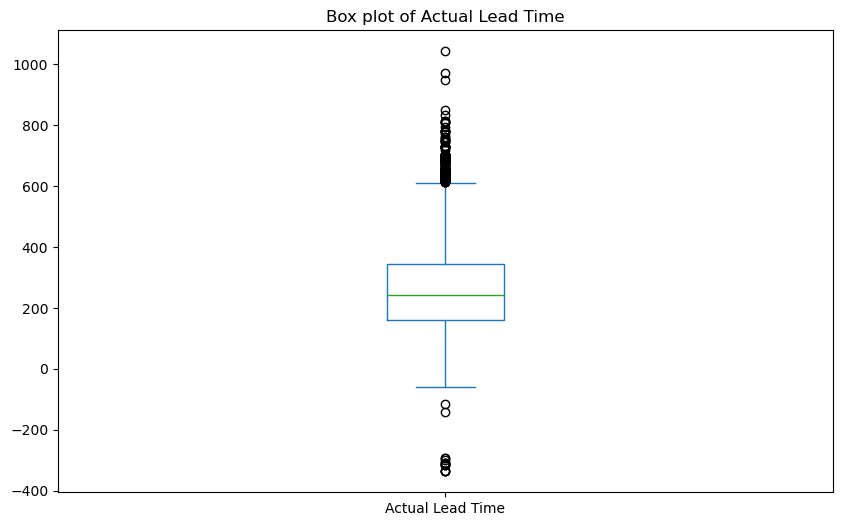

In [14]:
# Assuming df is your DataFrame and matplotlib.pyplot is imported as plt
plt.figure(figsize=(10, 6))
df['Actual Lead Time'].plot(kind='box')
plt.title('Box plot of Actual Lead Time')
plt.show()

In [15]:
#Removeing outliers for acutal lead time
Q1 = df['Actual Lead Time'].quantile(0.25)
Q3 = df['Actual Lead Time'].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df['Actual Lead Time'] < (Q1 - 1.5 * IQR)) | (df['Actual Lead Time'] > (Q3 + 1.5 * IQR)))]

In [16]:
df.shape

(14997, 12)

In [17]:
df

,Country,Continent,Transportation Mode,Order Type,Fulfillment Method,Product Category,Vendor Incoterm,Reason Code,Item Tracer Category,Quality Assurance,Manufacture,Actual Lead Time
10,Zambia,Africa,Land,Purchase Order,Direct Drop,Laboratory Consumables,DDP,NoDelay,Laboratory,-63.5,90.751057,229
11,Mozambique,Africa,Land,Purchase Order,Direct Drop,Laboratory Consumables,DDP,NoDelay,Laboratory,-63.5,90.751057,111
12,Mozambique,Africa,Land,Purchase Order,Direct Drop,Laboratory Consumables,DDP,NoDelay,Laboratory,-63.5,90.751057,184
26,Congo DRC,Africa,Land,Purchase Order,Direct Drop,Laboratory Consumables,DDP,NoDelay,Laboratory,-63.5,90.751057,67
27,Congo DRC,Africa,Land,Purchase Order,Direct Drop,Laboratory Consumables,DDP,NoDelay,Laboratory,-63.5,90.751057,67
...,...,...,...,...,...,...,...,...,...,...,...,...
38497,Zambia,Africa,Sea,Purchase Order,Direct Drop,Malaria Pharmaceuticals,FCA,AD,Severe Malaria Meds,95.0,35.000000,280
38498,Zambia,Africa,Air,Purchase Order,Direct Drop,Malaria Pharmaceuticals,FCA,SD,Severe Malaria Meds,17.0,42.000000,303
38499,Niger,Africa,Air,Purchase Order,Direct Drop,Malaria Pharmaceuticals,FCA,AD,Severe Malaria Meds,42.0,-3.000000,206
38500,Zimbabwe,Africa,Air,Purchase Order,Direct Drop,Essential Medicines,FCA,NoDelay,Other Pharma,35.0,75.648332,298


An overview of what the dataframe would look like after processing and before being dump to machine learning model

In [18]:
# Assuming df is your DataFrame
df_continent = df.drop('Country', axis=1)
df_country = df.drop('Continent', axis=1)

In [19]:
df_continent

,Continent,Transportation Mode,Order Type,Fulfillment Method,Product Category,Vendor Incoterm,Reason Code,Item Tracer Category,Quality Assurance,Manufacture,Actual Lead Time
10,Africa,Land,Purchase Order,Direct Drop,Laboratory Consumables,DDP,NoDelay,Laboratory,-63.5,90.751057,229
11,Africa,Land,Purchase Order,Direct Drop,Laboratory Consumables,DDP,NoDelay,Laboratory,-63.5,90.751057,111
12,Africa,Land,Purchase Order,Direct Drop,Laboratory Consumables,DDP,NoDelay,Laboratory,-63.5,90.751057,184
26,Africa,Land,Purchase Order,Direct Drop,Laboratory Consumables,DDP,NoDelay,Laboratory,-63.5,90.751057,67
27,Africa,Land,Purchase Order,Direct Drop,Laboratory Consumables,DDP,NoDelay,Laboratory,-63.5,90.751057,67
...,...,...,...,...,...,...,...,...,...,...,...
38497,Africa,Sea,Purchase Order,Direct Drop,Malaria Pharmaceuticals,FCA,AD,Severe Malaria Meds,95.0,35.000000,280
38498,Africa,Air,Purchase Order,Direct Drop,Malaria Pharmaceuticals,FCA,SD,Severe Malaria Meds,17.0,42.000000,303
38499,Africa,Air,Purchase Order,Direct Drop,Malaria Pharmaceuticals,FCA,AD,Severe Malaria Meds,42.0,-3.000000,206
38500,Africa,Air,Purchase Order,Direct Drop,Essential Medicines,FCA,NoDelay,Other Pharma,35.0,75.648332,298


# Regression model for country based - Sklearn

In [20]:
# Assuming df is your DataFrame
columns_to_encode = ['Country', 'Transportation Mode', 'Order Type', 'Fulfillment Method', 'Product Category', 'Vendor Incoterm', 'Reason Code', 'Item Tracer Category']
df_encoded = pd.get_dummies(df_country, columns=columns_to_encode)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from math import sqrt

# Assuming df_encoded is your DataFrame
X = df_encoded.drop('Actual Lead Time', axis=1)
y = df_encoded['Actual Lead Time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Random Forest', RandomForestRegressor()),
    ('Support Vector Machines', SVR())
]

for name, model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    print(f'{name} RMSE: {rmse}, R2: {r2}')

Linear Regression RMSE: 297609289.1809028, R2: -5801700356352.44
Decision Tree RMSE: 75.31612253477122, R2: 0.6284320586172845
Random Forest RMSE: 65.34385839596494, R2: 0.7203132583087739
Support Vector Machines RMSE: 111.73601774321645, R2: 0.1821969840362596


# Regression model for continent based - Sklearn

In [22]:
# Assuming df is your DataFrame
columns_to_encode = ['Continent', 'Transportation Mode', 'Order Type', 'Fulfillment Method', 'Product Category', 'Vendor Incoterm', 'Reason Code', 'Item Tracer Category']
df_encoded = pd.get_dummies(df_continent, columns=columns_to_encode)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from math import sqrt

# Assuming df_encoded is your DataFrame
X = df_encoded.drop('Actual Lead Time', axis=1)
y = df_encoded['Actual Lead Time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Random Forest', RandomForestRegressor()),
    ('Support Vector Machines', SVR())
]

for name, model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    print(f'{name} RMSE: {rmse}, R2: {r2}')

Linear Regression RMSE: 107952673.36401185, R2: -763359532392.2144
Decision Tree RMSE: 82.56022449664421, R2: 0.553517891899242
Random Forest RMSE: 74.70597362112001, R2: 0.6344279450905116
Support Vector Machines RMSE: 111.7472968087871, R2: 0.18203187130747156


# Neural Network model for country based

In [24]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Training on:', device)

# Assuming df_encoded is your DataFrame
X = df_encoded.drop('Actual Lead Time', axis=1)
y = df_encoded['Actual Lead Time']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors and move to the device
X_train_torch = torch.from_numpy(X_train).float().to(device)
y_train_torch = torch.from_numpy(y_train.values).float().to(device)
X_test_torch = torch.from_numpy(X_test).float().to(device)
y_test_torch = torch.from_numpy(y_test.values).float().to(device)

# Create a DataLoader
train_data = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_data, batch_size=32)

# Define the MLP
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 25)
        self.fc4 = nn.Linear(25, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the model and move to the device
model = MLP(X_train.shape[1]).to(device)

# Define the loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
for epoch in range(100):
    for inputs, targets in train_loader:
        # Move inputs and targets to the device
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

# Test the model
model.eval()
with torch.no_grad():
    predictions = model(X_test_torch).squeeze()
    rmse = torch.sqrt(criterion(predictions, y_test_torch))
    print('RMSE: ', rmse.item())

Training on: cuda


/home/nhatthuan97/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/100], Loss: 799.4494
Epoch [2/100], Loss: 1450.1226
Epoch [3/100], Loss: 1592.4357
Epoch [4/100], Loss: 881.7473
Epoch [5/100], Loss: 616.8837
Epoch [6/100], Loss: 616.0903
Epoch [7/100], Loss: 511.2087
Epoch [8/100], Loss: 445.9453
Epoch [9/100], Loss: 363.0404
Epoch [10/100], Loss: 427.0678
Epoch [11/100], Loss: 376.9882
Epoch [12/100], Loss: 461.7823
Epoch [13/100], Loss: 299.0378
Epoch [14/100], Loss: 331.3232
Epoch [15/100], Loss: 353.0019
Epoch [16/100], Loss: 351.8870
Epoch [17/100], Loss: 387.1142
Epoch [18/100], Loss: 360.5867
Epoch [19/100], Loss: 346.9577
Epoch [20/100], Loss: 356.4863
Epoch [21/100], Loss: 312.7904
Epoch [22/100], Loss: 373.1324
Epoch [23/100], Loss: 443.6848
Epoch [24/100], Loss: 382.4741
Epoch [25/100], Loss: 403.8998
Epoch [26/100], Loss: 415.3017
Epoch [27/100], Loss: 505.0642
Epoch [28/100], Loss: 428.7849
Epoch [29/100], Loss: 679.6079
Epoch [30/100], Loss: 463.1631
Epoch [31/100], Loss: 520.7987
Epoch [32/100], Loss: 450.0515
Epoch [33/100],

In [25]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Training on:', device)


# Split data into features and target
X = df_encoded.drop('Actual Lead Time', axis=1).values
y = df_encoded['Actual Lead Time'].values.reshape(-1, 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (important for neural network models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for CNN input, assuming each feature will be treated as a 'channel'
X_train_cnn = np.expand_dims(X_train_scaled, axis=2)  # Add an extra dimension
X_test_cnn = np.expand_dims(X_test_scaled, axis=2)

# Convert arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_cnn, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_cnn, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader instances
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

class CNNRegression(nn.Module):
    def __init__(self, input_channels):
        super(CNNRegression, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = torch.flatten(x, start_dim=1)  # Flatten the tensor for the fully connected layer
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Assuming the length of X's columns is the number of input channels
input_channels = X_train_cnn.shape[1]
model = CNNRegression(input_channels=input_channels).to(device)

print(model)

from torch.optim import Adam
from torch.nn import MSELoss
from math import sqrt

# Define the loss function and the optimizer
criterion = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate on the test data
    model.eval()
    with torch.no_grad():
        total_loss = 0
        total_samples = 0
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)
        rmse = sqrt(total_loss / total_samples)
        print(f'Epoch {epoch+1}/{num_epochs}, RMSE: {rmse:.4f}')


Training on: cuda
CNNRegression(
  (conv1): Conv1d(190, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


/home/nhatthuan97/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch 1/100, RMSE: 99.9053
Epoch 2/100, RMSE: 96.0635
Epoch 3/100, RMSE: 94.5140
Epoch 4/100, RMSE: 94.4186
Epoch 5/100, RMSE: 92.9709
Epoch 6/100, RMSE: 91.5300
Epoch 7/100, RMSE: 91.1223
Epoch 8/100, RMSE: 91.2400
Epoch 9/100, RMSE: 90.6212
Epoch 10/100, RMSE: 89.9882
Epoch 11/100, RMSE: 89.2775
Epoch 12/100, RMSE: 89.7166
Epoch 13/100, RMSE: 88.8359
Epoch 14/100, RMSE: 89.1822
Epoch 15/100, RMSE: 88.3740
Epoch 16/100, RMSE: 88.4292
Epoch 17/100, RMSE: 88.7621
Epoch 18/100, RMSE: 88.5664
Epoch 19/100, RMSE: 89.5722
Epoch 20/100, RMSE: 88.2632
Epoch 21/100, RMSE: 88.2561
Epoch 22/100, RMSE: 88.3247
Epoch 23/100, RMSE: 88.0519
Epoch 24/100, RMSE: 88.3950
Epoch 25/100, RMSE: 88.5317
Epoch 26/100, RMSE: 88.4235
Epoch 27/100, RMSE: 88.4206
Epoch 28/100, RMSE: 88.4368
Epoch 29/100, RMSE: 88.3349
Epoch 30/100, RMSE: 88.3165
Epoch 31/100, RMSE: 88.2763
Epoch 32/100, RMSE: 87.9651
Epoch 33/100, RMSE: 87.9584
Epoch 34/100, RMSE: 87.8699
Epoch 35/100, RMSE: 87.8136
Epoch 36/100, RMSE: 87.8641
E